In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from sympy import Matrix
import matplotlib.animation as animation

# from car import Car
from tools_cv import *
from tools_kinematics import rotation, add_translation
%matplotlib inline

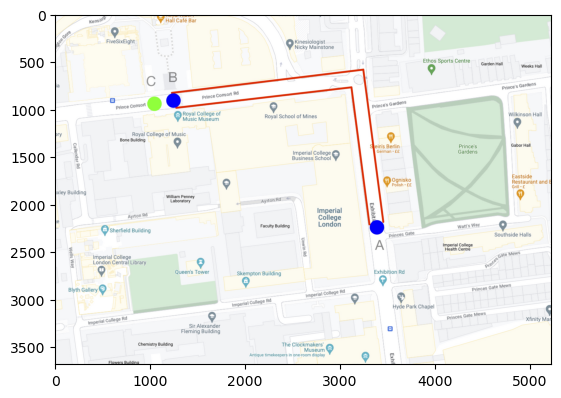

In [2]:
img = cv2.imread('Figures/CWMap.jpg')  # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_img(img)

In [3]:
img_R, mask_R = extract_color(img, 'R')
img_G, mask_G = extract_color(img, 'G')
img_B, mask_B = extract_color(img, 'B')

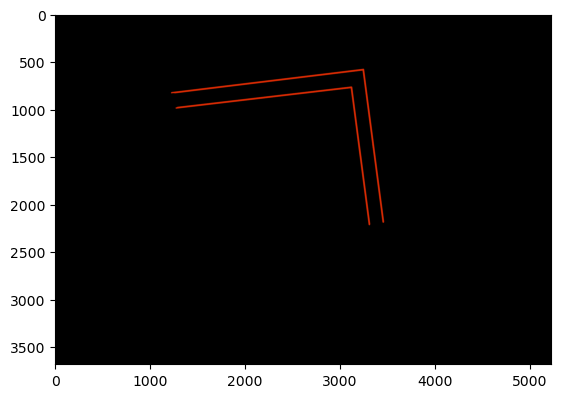

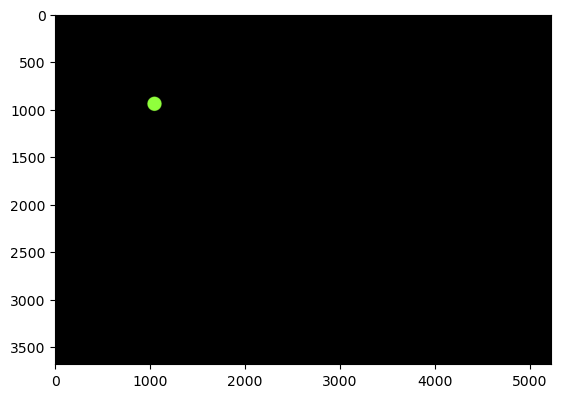

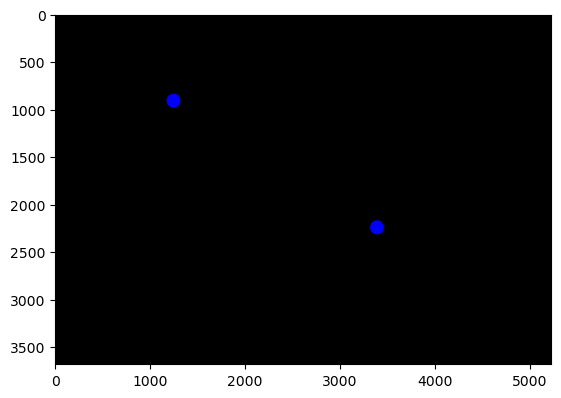

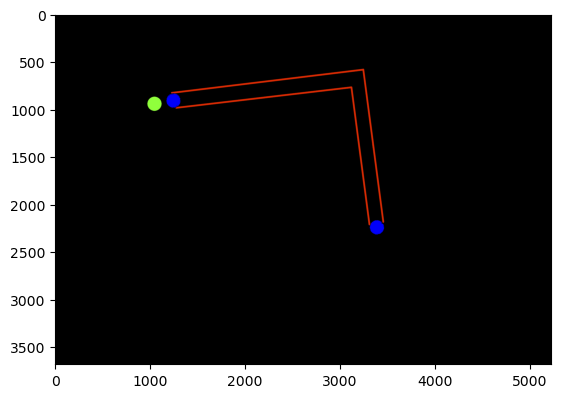

In [4]:
show_img(img_R)
show_img(img_G)
show_img(img_B)
show_img(img_R + img_G + img_B)

## Check if noise present (use large marker size)

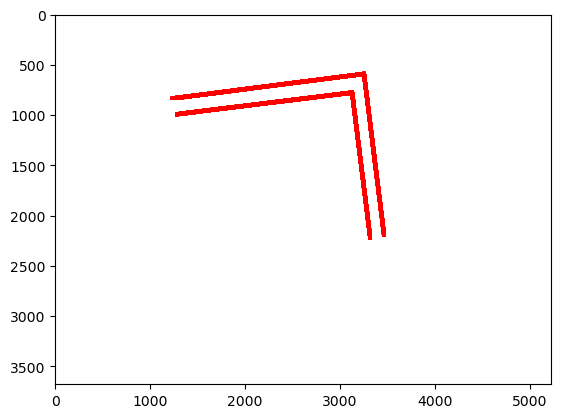

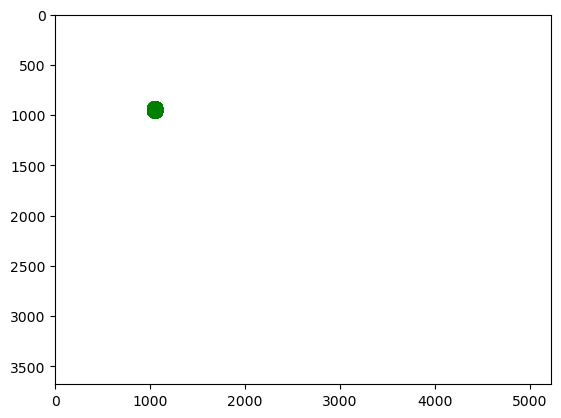

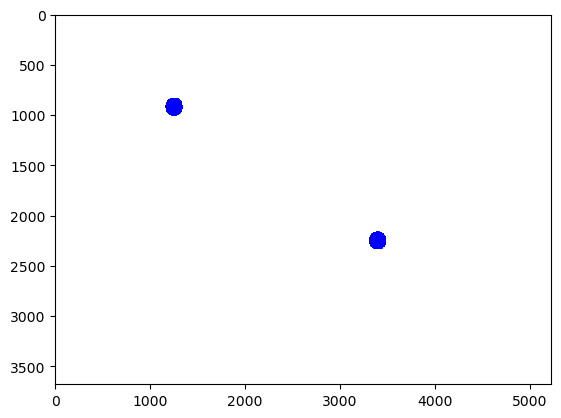

In [5]:
R_coords = mask2xy(mask_R)
G_coords = mask2xy(mask_G)
B_coords = mask2xy(mask_B)

plt.scatter(R_coords[:, 0], R_coords[:, 1], c='r', s=1, linewidth=1)
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.show()
plt.scatter(G_coords[:, 0], G_coords[:, 1], c='g', s=1, linewidth=1)
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.show()
plt.scatter(B_coords[:, 0], B_coords[:, 1], c='b', s=1, linewidth=1)
plt.xlim([0, img.shape[1]])
plt.ylim([img.shape[0], 0])
plt.show()

## Debug Space

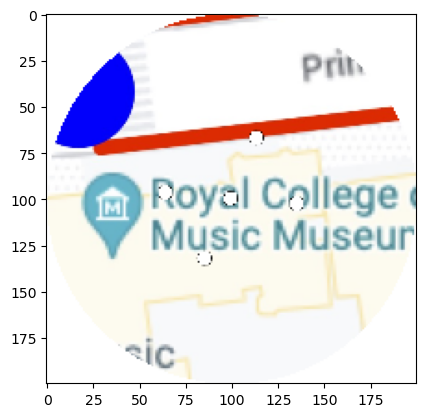

In [42]:
zoom_factor = 2 / 5
img = cv2.imread('Figures/CWMap.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

car_origin3d = np.array([1453.9377, 1054.2294])



cv2.circle(img, (1542, 1061), 10, (0, 0, 0), -1)
cv2.circle(img, (1488, 972), 10, (0, 0, 0), -1)
cv2.circle(img, (1418, 1135), 10, (0, 0, 0), -1)
cv2.circle(img, (1365, 1046), 10, (0, 0, 0), -1)
cv2.circle(img, (int(car_origin3d[0]), int(car_origin3d[1])), 10, (0, 0, 0), -1)



car_center = car_origin3d
car_center[0], car_center[1] = car_center[1], car_center[0]

radius = 100
topleft = (600, 0)
        

w = 200
h = 200

crop_size_w = radius / zoom_factor
crop_size_h = radius / zoom_factor
start_row = np.round(car_center[0] - crop_size_w).astype(np.int32)
start_col = np.round(car_center[1] - crop_size_h).astype(np.int32)
end_row = np.round(car_center[0] + crop_size_w).astype(np.int32)
end_col = np.round(car_center[1] + crop_size_h).astype(np.int32)
pre_cropped = img[start_row:end_row, start_col:end_col]

scaled = cv2.resize(pre_cropped, (w, h),
                         interpolation=cv2.INTER_LINEAR)

padded = scaled
# Circular crop
xc = padded.shape[0] // 2
yc = padded.shape[1] // 2
mask = np.zeros_like(padded, dtype=np.uint8)
mask = cv2.circle(mask, (xc, yc), radius, (255, 255, 255), -1)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
cropped = cv2.bitwise_and(padded, padded, mask=mask)
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
black_pixels = np.where(gray == 0)
res = cropped.copy()
res[black_pixels] = [255, 255, 255]
# res = np.fliplr(res)
plt.imshow(res)

## Depreciated

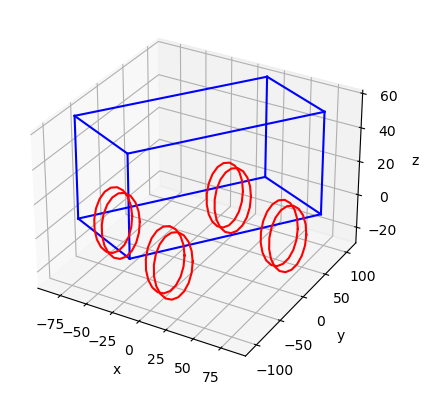

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mycar = Car(length=5*40, width=2*40, height=1.5*40,
            wheel_radius=0.5*40, wheel_width=0.3*40,
            wheel_offset=0.2*40, wheel_base=3*40)
R = rotation(np.pi/3, 'z')
T = add_translation(R)
mycar.update_plot(ax, T)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_xlim([-3, 3])
# ax.set_ylim([-3, 3])
# ax.set_zlim([-2, 2])

plt.show()

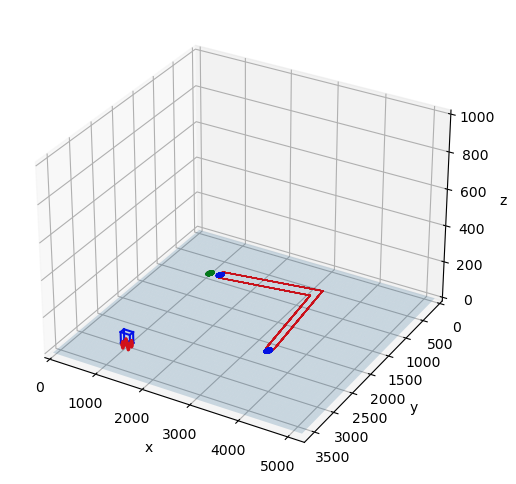

In [7]:
%matplotlib inline
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])
ax.set_zlim([0, 1000])

ax.scatter(R_coords[:, 0], R_coords[:, 1], 0, c='r', s=0.1, linewidth=0.1)
ax.scatter(G_coords[:, 0], G_coords[:, 1], 0, c='g', s=0.1, linewidth=0.1)
ax.scatter(B_coords[:, 0], B_coords[:, 1], 0, c='b', s=0.1, linewidth=0.1)

x, y = np.meshgrid(np.linspace(0, img.shape[1], 1000), np.linspace(0, img.shape[0], 1000))
z = np.zeros_like(x)
ax.plot_surface(x, y, z, alpha=0.2)

# draw the car:

scalr = 40
mycar = Car(length=5*scalr, width=2*scalr, height=1.5*scalr,
            wheel_radius=0.5*scalr, wheel_width=0.3*scalr,
            wheel_offset=0.2*scalr, wheel_base=3*scalr)
R = rotation(np.pi, 'z')
T = add_translation(R, Matrix([1000, 3000, 0, 1]))
mycar.update_plot(ax, T)

plt.show()

<IPython.core.display.Javascript object>


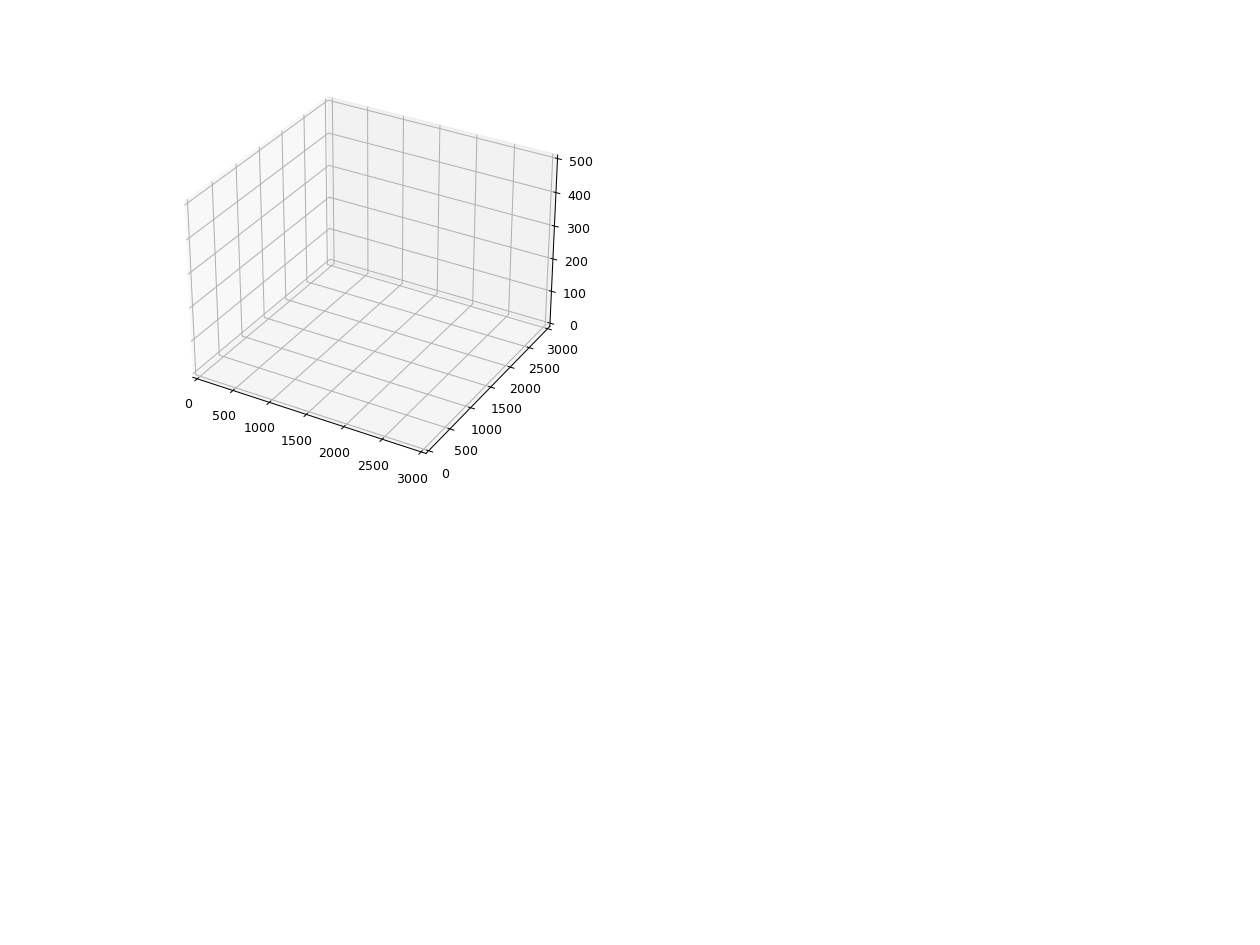

Time taken: 13.28436 seconds


In [13]:
start_time = time.time()

%matplotlib notebook

plt.ion()

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([0, 3000])
ax.set_ylim([0, 3000])
ax.set_zlim([0, 500])
# ax.set_xlim([0, img.shape[1]])
# ax.set_ylim([img.shape[0], 0])
# ax.set_zlim([0, 1000])

ax.scatter(R_coords[:, 0], R_coords[:, 1], 0, c='r', s=0.1, linewidth=0.1)
ax.scatter(G_coords[:, 0], G_coords[:, 1], 0, c='g', s=0.1, linewidth=0.1)
ax.scatter(B_coords[:, 0], B_coords[:, 1], 0, c='b', s=0.1, linewidth=0.1)

x, y = np.meshgrid(np.linspace(0, img.shape[1], 1000), np.linspace(0, img.shape[0], 1000))
z = np.zeros_like(x)
ax.plot_surface(x, y, z, alpha=0.2)

# draw the car:
scalr = 40
mycar = Car(length=5*scalr, width=2*scalr, height=1.5*scalr,
            wheel_radius=0.5*scalr, wheel_width=0.3*scalr,
            wheel_offset=0.2*scalr, wheel_base=3*scalr)

for i in range(100):
    ax.cla()
    R = rotation(-np.pi - i/10, 'z')
    T = add_translation(R, Matrix([i*10, 3000, 0, 1]))
    mycar.update_plot(ax, T)
#     mycar.plot_body(ax, T)
#     mycar.plot_wheels(ax, T)
    
    ax.set_xlim([0, 3000])
    ax.set_ylim([0, 3000])
    ax.set_zlim([0, 500])
    fig.canvas.draw()
    fig.canvas.flush_events()
    
plt.show()

end_time = time.time()

print(f"Time taken: {end_time - start_time:.5f} seconds")

<IPython.core.display.Javascript object>


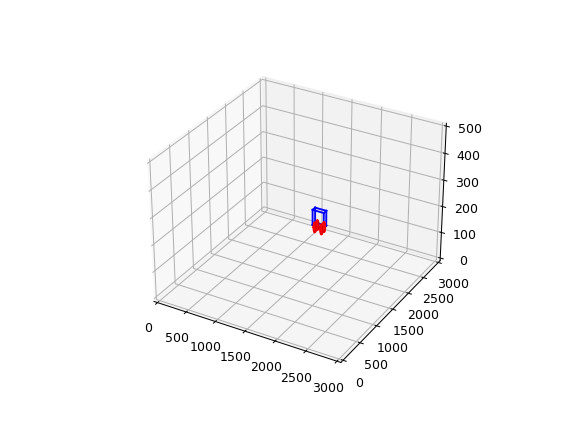

Time taken: 0.08972 seconds


In [16]:
start_time = time.time()

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mycar = Car(length=5*40, width=2*40, height=1.5*40,
            wheel_radius=0.5*40, wheel_width=0.3*40,
            wheel_offset=0.2*40, wheel_base=3*40)
R = rotation(np.pi/3, 'z')
T = add_translation(R)
mycar.update_plot(ax, T)
# mycar.plot_body(ax, T)
# mycar.plot_wheels(ax, T)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


def update(frame, ax):
    ax.cla()
    R = rotation(np.pi, 'z')
    T = add_translation(R, Matrix([frame*10, 3000, 0, 1]))
    mycar.update_plot(ax, T)
#     mycar.plot_body(ax, T)
#     mycar.plot_wheels(ax, T)
    
    ax.set_xlim([0, 3000])
    ax.set_ylim([0, 3000])
    ax.set_zlim([0, 500])

    
ani = animation.FuncAnimation(fig, update, fargs=(ax,), frames=np.arange(0, 100), interval=10, repeat=False)

plt.show()

end_time = time.time()

print(f"Time taken: {end_time - start_time:.5f} seconds")